<a href="https://colab.research.google.com/github/aaaarushi/brain-tumor-classification-example/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

# getting the data
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Inno Board Resources/Curriculum /CS/ML code/data/Brain Tumor/"
!unzip "/content/drive/My Drive/Inno Board Resources/Curriculum /CS/ML code/data/Brain Tumor/images.zip" -d "/content"

In [ ]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("running on device", device)

running on device cuda


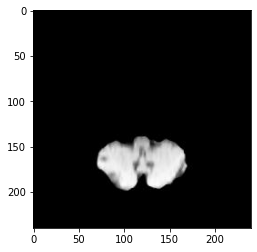

In [ ]:
raw = pd.read_csv(path + "Brain Tumor.csv")
raw = raw.to_numpy()

N = raw.shape[0]
img_size = (3, 160, 160)

X_data = np.empty((N, 3, 160, 160))
for i in range(N):
    img = Image.open("/content/images/Image{}.jpg".format(i+1))
    img = img.crop((40, 40, 200, 200))
    row = np.array(img)
    X_data[i, :] = np.moveaxis(row, -1, 0)

X_data = np.array(X_data, dtype='float32')
y_data = np.array(raw[:, 1], dtype='int32')

img = mpimg.imread("/content/images/Image1.jpg")
plt.imshow(img)



In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25)

class TrainDataset(Dataset):
    def __init__(self):
        self.X_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(y_train)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

train_dataset = TrainDataset()
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [ ]:
def train(model, train_loader, X_val, y_val, lr, mu, epochs=10):
    
    model = model.to(device=device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mu)
    
    print("training model with learning rate %s and momentum %s..." % (lr, mu))
    
    for epoch in range(epochs):
        for it, data in enumerate(train_loader):
            X_batch, y_batch = data
            X_batch = X_batch.to(device=device, dtype=torch.float32)
            y_batch = y_batch.to(device=device, dtype=torch.long)
            
            model.train()
            scores = model(X_batch)
            loss = criterion(scores, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print loss and accuracies every 10 iterations
            if it % 10 == 0:
                print("iteration:", it, "\t loss:", loss.item())
                accuracy(model, X_val, y_val, "validation")
    
    
def accuracy(model, X, y, data_type):
    model.eval()
    with torch.no_grad():
        X = X.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(X)
        _, y_pred = scores.max(1)
        num_correct = torch.sum(y == y_pred)
        acc = float(num_correct) / X.shape[0]
        print("\t", data_type, "accuracy:", acc)

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

channels = [32, 64, 128, 64, 32, 16]
num_pool = 3
final_img_size = int((160 / (2 ** num_pool))**2)

model = nn.Sequential(
    nn.Conv2d(3, channels[0], (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(channels[0], channels[1], (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2), stride=2),
    nn.BatchNorm2d(channels[1]),
    nn.Conv2d(channels[1], channels[2], (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(channels[2], channels[3], (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2), stride=2),
    nn.BatchNorm2d(channels[3]),
    nn.Conv2d(channels[3], channels[4], (3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(channels[4], channels[5], (3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d((2, 2), stride=2),
    Flatten(),
    nn.Linear(channels[5] * final_img_size, 2)
)

final_img_size

400

In [ ]:
train(model, train_loader, X_val, y_val, 5e-3, 0.5)

training model with learning rate 0.005 and momentum 0.5...
iteration: 0 	 loss: 0.6909938454627991
	 validation accuracy: 0.5590969455511288
iteration: 10 	 loss: 0.5178089141845703
	 validation accuracy: 0.7556440903054449
iteration: 20 	 loss: 0.32661348581314087
	 validation accuracy: 0.8233731739707836
iteration: 30 	 loss: 0.29705822467803955
	 validation accuracy: 0.8273572377158035
iteration: 40 	 loss: 0.4985441565513611
	 validation accuracy: 0.8565737051792829
iteration: 50 	 loss: 0.2617220878601074
	 validation accuracy: 0.8207171314741036
iteration: 60 	 loss: 0.21564005315303802
	 validation accuracy: 0.8711819389110226
iteration: 70 	 loss: 0.496338814496994
	 validation accuracy: 0.8034528552456839
iteration: 0 	 loss: 0.4282478988170624
	 validation accuracy: 0.8087649402390438
iteration: 10 	 loss: 0.2502305209636688
	 validation accuracy: 0.8804780876494024
iteration: 20 	 loss: 0.23302359879016876
	 validation accuracy: 0.8167330677290837
iteration: 30 	 loss: 0.16

In [ ]:
accuracy(model, X_val, y_val, "validation")
accuracy(model, X_test, y_test, "test")

	 validation accuracy: 0.9362549800796812
	 test accuracy: 0.9243027888446215
